**Import libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import f_classif, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency


**Read dataset**

In [2]:
Path=os.path.join(os.getcwd(),'..','dataset','churn-data.csv')
data=pd.read_csv(Path)
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
#adjust col names
data.columns=data.columns.str.lower().str.strip().str.replace(' ','_')

In [4]:
#drop first three feature
data.drop(columns=['rownumber','customerid','surname'],axis=1,inplace=True)

In [5]:
df=data.copy()

**EDA**

* `Univariate Viz`

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   geography        10000 non-null  object 
 2   gender           10000 non-null  object 
 3   age              10000 non-null  int64  
 4   tenure           10000 non-null  int64  
 5   balance          10000 non-null  float64
 6   numofproducts    10000 non-null  int64  
 7   hascrcard        10000 non-null  int64  
 8   isactivemember   10000 non-null  int64  
 9   estimatedsalary  10000 non-null  float64
 10  exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [7]:
df.isna().sum()

creditscore        0
geography          0
gender             0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0
isactivemember     0
estimatedsalary    0
exited             0
dtype: int64

In [8]:
df.dtypes

creditscore          int64
geography           object
gender              object
age                  int64
tenure               int64
balance            float64
numofproducts        int64
hascrcard            int64
isactivemember       int64
estimatedsalary    float64
exited               int64
dtype: object

In [9]:
# Numerical cols
df.describe()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [10]:
df[['exited','age','tenure','balance','estimatedsalary','numofproducts']].corr()['exited']


exited             1.000000
age                0.285323
tenure            -0.014001
balance            0.118533
estimatedsalary    0.012097
numofproducts     -0.047820
Name: exited, dtype: float64

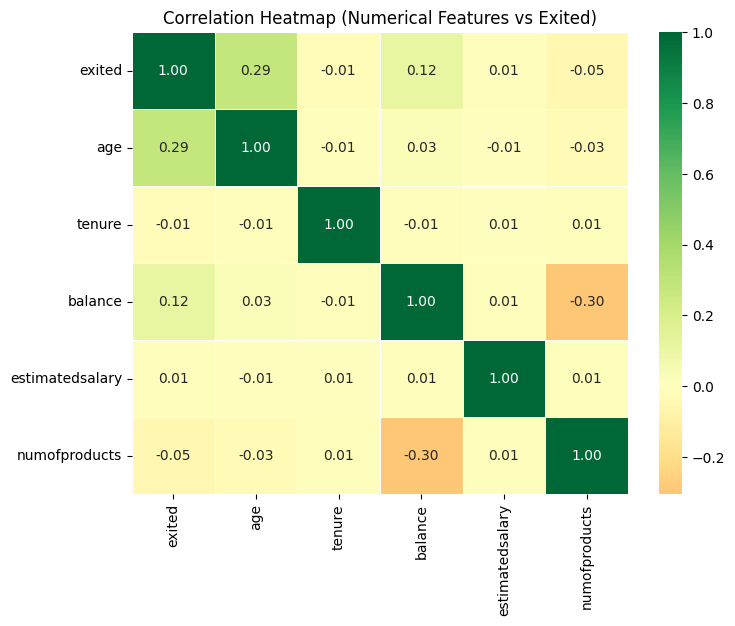

In [11]:
corr = df[[
    'exited',
    'age',
    'tenure',
    'balance',
    'estimatedsalary',
    'numofproducts'
]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    center=0,
    linewidths=0.5
)

plt.title("Correlation Heatmap (Numerical Features vs Exited)")
plt.show()

=== HASCRCARD ===
Crosstab (Percentages):
exited             0          1
hascrcard                      
0          79.185059  20.814941
1          79.815734  20.184266 



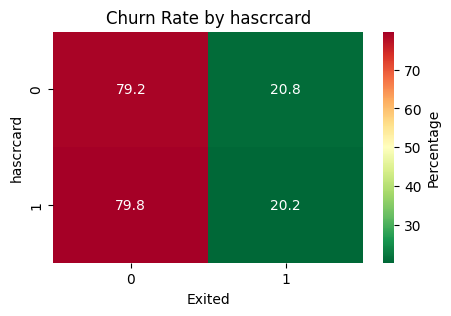

Chi-Square p-value: 0.49237

-----------------------------

=== ISACTIVEMEMBER ===
Crosstab (Percentages):
exited                  0          1
isactivemember                      
0               73.149103  26.850897
1               85.730926  14.269074 



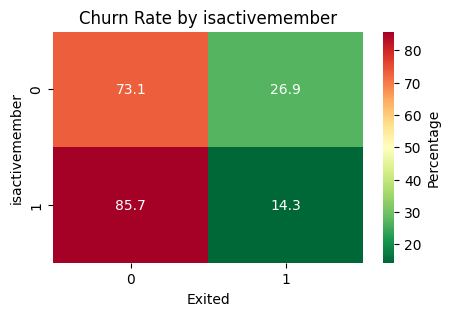

Chi-Square p-value: 0.00000

-----------------------------



In [12]:
 
# List of Binary Features
binary_features = ['hascrcard', 'isactivemember']

for feature in binary_features:
    print(f"=== {feature.upper()} ===")
    
    #  Crosstab (Percentages)
    ct = pd.crosstab(df[feature], df['exited'], normalize='index')*100
    print("Crosstab (Percentages):")
    print(ct, "\n")
    
    #  Heatmap Visualization
    plt.figure(figsize=(5,3))
    sns.heatmap(
        ct,
        annot=True,
        fmt=".1f",
        cmap="RdYlGn_r", 
        cbar_kws={'label': 'Percentage'}
    )
    plt.title(f"Churn Rate by {feature}")
    plt.ylabel(feature)
    plt.xlabel("Exited")
    plt.show()
    
    # Chi-Square Test
    ct_counts = pd.crosstab(df[feature], df['exited'])
    chi2, p, dof, expected = chi2_contingency(ct_counts)
    print(f"Chi-Square p-value: {p:.5f}")
    print("\n-----------------------------\n")


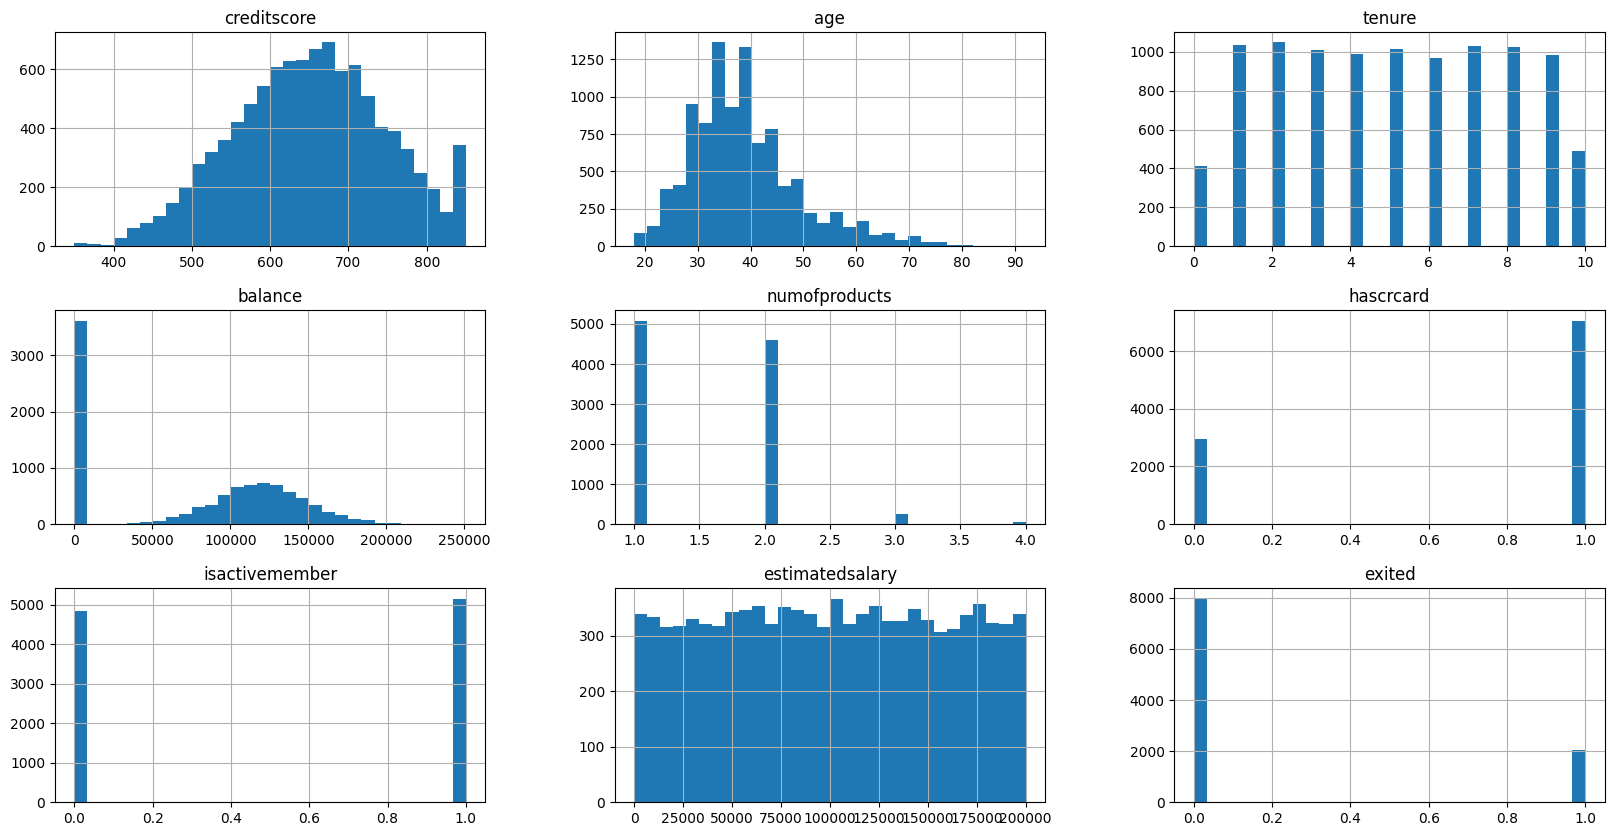

In [13]:
# Numerical cols
df.hist(bins=30, figsize=(20, 10))
plt.show()

In [14]:
#creditscore
df['creditscore'].describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: creditscore, dtype: float64

In [15]:
df['creditscore_bin'] = pd.cut(
    df['creditscore'],
    bins=[300, 580, 670, 740, 850],
    labels=['Low', 'Fair', 'Good', 'Excellent']
)

pd.crosstab(df['creditscore_bin'], df['exited'], normalize='index') * 100


exited,0,1
creditscore_bin,,
Low,77.852069,22.147931
Fair,79.611940,20.388060
Good,81.184814,18.815186
Excellent,79.946237,20.053763


In [16]:
mean_scores = df.groupby('exited')['creditscore'].mean()
difference = mean_scores[0] - mean_scores[1]  # Stayed - Churned
percent_diff = (difference / mean_scores[0]) * 100

difference, percent_diff


(6.5016987316954555, 0.9974176350252656)

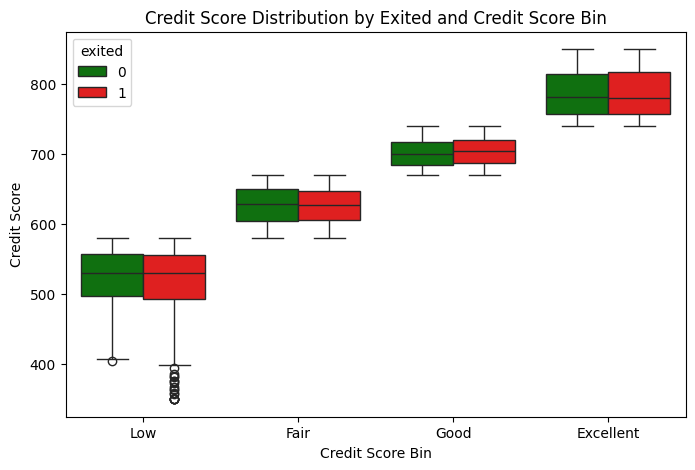

In [17]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=df,
    x='creditscore_bin',
    y='creditscore',    
    hue='exited',          
    palette=['green','red']
)
plt.title("Credit Score Distribution by Exited and Credit Score Bin")
plt.xlabel("Credit Score Bin")
plt.ylabel("Credit Score")
plt.show()


In [18]:
# All customers with a Credit Score lower than 400
outliers = df[df['creditscore'] < 400]
print(outliers[['creditscore', 'exited']])
print(f"Number of outliers: {len(outliers)}")


      creditscore  exited
7             376       1
942           376       1
1193          363       1
1201          399       1
1405          359       1
1631          350       1
1838          350       1
1962          358       1
2473          351       1
2579          365       1
5285          386       1
5494          383       1
6253          395       1
8154          367       1
8723          350       1
8762          350       1
9210          382       1
9356          373       1
9624          350       1
Number of outliers: 19


In [19]:
#Age
df['age'].describe()


count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64

In [20]:
from scipy.stats import f_oneway

# Exited for groups of age
age_exited_0 = df[df['exited'] == 0]['age']
age_exited_1 = df[df['exited'] == 1]['age']

# ANOVA test
f_stat, p_value = f_oneway(age_exited_0, age_exited_1)

f_stat, p_value


(886.0632749090969, 1.2399313093445346e-186)

In [21]:
#drop lower than 70
df = df[df['age'] <= 70]


In [22]:
df.groupby('exited')['age'].agg(['median', 'count'])


,median,count
exited,,
0,36.0,7841
1,45.0,2026


In [23]:
age_bins = [18, 30, 40, 50, 60, 70]
age_labels = ['18-30', '31-40', '41-50', '51-60', '61-70']

df['age_group'] = pd.cut(
    df['age'],
    bins=age_bins,
    labels=age_labels
)


In [24]:
#Churn rate increases significantly with age, especially after 40.
#The highest churn is observed among customers aged 51–60, where more than half of the customers leave.
#Interestingly, churn slightly decreases after 60, suggesting that customers who remain beyond this age are more loyal.
age_churn_rate = pd.crosstab(
    df['age_group'],
    df['exited'],
    normalize='index'
) * 100

age_churn_rate


exited,0,1
age_group,,
18-30,92.497431,7.502569
31-40,87.912829,12.087171
41-50,66.034483,33.965517
51-60,43.789210,56.210790
61-70,68.580060,31.419940


In [25]:
#Tenure
df['tenure'].unique()

array([ 2,  1,  8,  7,  4,  6,  3, 10,  5,  9,  0], dtype=int64)

In [26]:
df['tenure'].value_counts()

tenure
2     1034
1     1024
7     1021
8     1012
3      996
5      994
4      977
9      973
6      950
10     480
0      406
Name: count, dtype: int64

In [27]:
# Tenure alone shows almost no difference between churned and retained customers (mean ≈ 5 years for both).
# Therefore, it is not sufficient by itself but can be useful when combined with other features like activity and age.
# Mean and median Tenure for each Exited group

tenure_stats = df.groupby('exited')['tenure'].agg(['mean', 'median', 'count'])
tenure_stats


,mean,median,count
exited,,,
0,5.034945,5.0,7841
1,4.925469,5.0,2026


In [28]:
df['balance'].describe()   

count      9867.000000
mean      76597.617276
std       62393.121800
min           0.000000
25%           0.000000
50%       97325.150000
75%      127677.095000
max      250898.090000
Name: balance, dtype: float64

In [29]:
bins = [0, 1000, 5000, 10000, 50000, df['balance'].max()]
labels = ['0-1k', '1k-5k', '5k-10k', '10k-50k', '50k+']
df['balance_group'] = pd.cut(df['balance'], bins=bins, labels=labels)


In [30]:
# Balance
#divide balance into groups
bins = [0, 20000, 50000, 100000, df['balance'].max()]
labels = ['0-20k','20-50k','50-100k','100k+']
df['balance_bin'] = pd.cut(df['balance'], bins=bins, labels=labels, include_lowest=True)

# Calculate the churn to each group
balance_churn = pd.crosstab(df['balance_bin'], df['exited'], normalize='index') * 100
balance_churn.columns = ['Stayed(%)','Exited(%)']
balance_churn


,Stayed(%),Exited(%)
balance_bin,,
0-20k,86.006730,13.993270
20-50k,65.217391,34.782609
50-100k,79.973118,20.026882
100k+,74.599494,25.400506


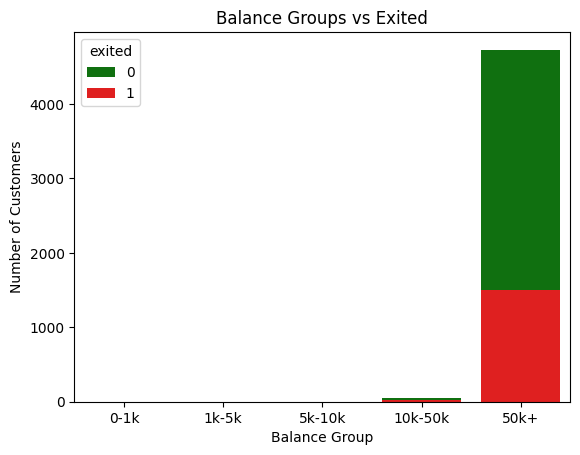

In [31]:
sns.countplot(data=df, x='balance_group', hue='exited', palette=['green','red'])
plt.title("Balance Groups vs Exited")
plt.xlabel("Balance Group")
plt.ylabel("Number of Customers")
plt.show()

In [32]:
# Mean, median, count of NumOfProducts لكل Exited
products_stats = df.groupby('exited')['numofproducts'].agg(['mean','median','count'])
products_stats


,mean,median,count
exited,,,
0,1.544701,2.0,7841
1,1.475321,1.0,2026


In [33]:
age_products_churn = pd.crosstab(
    index=[df['age_group'], df['numofproducts']],
    columns=df['exited'],
    normalize='index'
) * 100
age_products_churn.columns = ['Stayed(%)','Exited(%)']
age_products_churn


Stayed(%)   Exited(%)
age_group numofproducts                       
18-30     1              89.098999   10.901001
          2              97.337278    2.662722
          3              38.709677   61.290323
          4               0.000000  100.000000
31-40     1              83.149679   16.850321
          2              95.325390    4.674610
          3              28.571429   71.428571
          4               0.000000  100.000000
41-50     1              55.974338   44.025662
          2              87.052632   12.947368
          3               7.446809   92.553191
          4               0.000000  100.000000
51-60     1              36.200000   63.800000
          2              70.464135   29.535865
          3               2.127660   97.872340
          4               0.000000  100.000000
61-70     1              62.637363   37.362637
          2              83.333333   16.666667
          3              20.000000   80.000000
          4               0.000000  100.000000

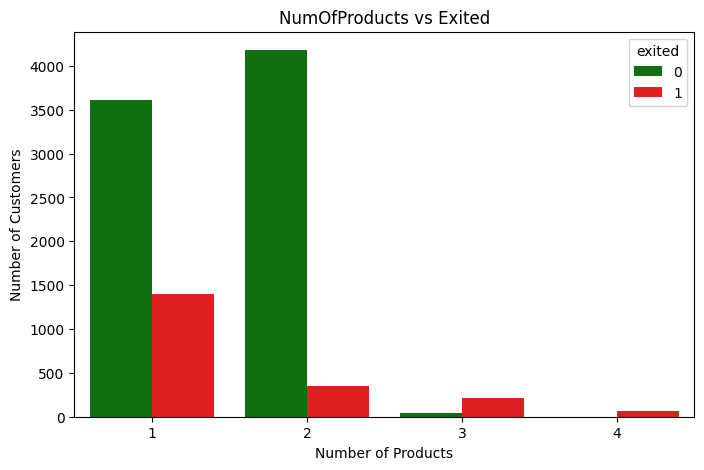

In [34]:
df = df[df['numofproducts'] >= 1]
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='numofproducts', hue='exited', palette=['green','red'])
plt.title("NumOfProducts vs Exited")
plt.xlabel("Number of Products")
plt.ylabel("Number of Customers")
plt.show()
df['num_products_group'] = df['numofproducts'].apply(lambda x: str(x) if x < 3 else '3+')

In [35]:
# Customers with more than 3 products
high_products = df[df['numofproducts'] > 3]

# Total number
total_high = high_products.shape[0]

# Number who exited (Exited=1)
churned_high = high_products[high_products['exited'] == 1].shape[0]

# Number who stayed (Exited=0)
stayed_high = high_products[high_products['exited'] == 0].shape[0]

print(f"Total customers with >3 products: {total_high}")
print(f"Number who exited: {churned_high}")
print(f"Number who stayed: {stayed_high}")


Total customers with >3 products: 60
Number who exited: 60
Number who stayed: 0


In [36]:
# Hascrcard
df['hascrcard'].unique()


array([1, 0], dtype=int64)

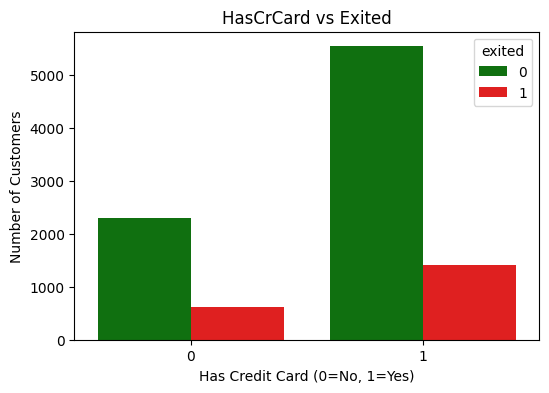

In [37]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='hascrcard', hue='exited', palette=['green','red'])
plt.title("HasCrCard vs Exited")
plt.xlabel("Has Credit Card (0=No, 1=Yes)")
plt.ylabel("Number of Customers")
plt.show()

In [38]:
#isactivemember
df['isactivemember'].unique()


array([1, 0], dtype=int64)

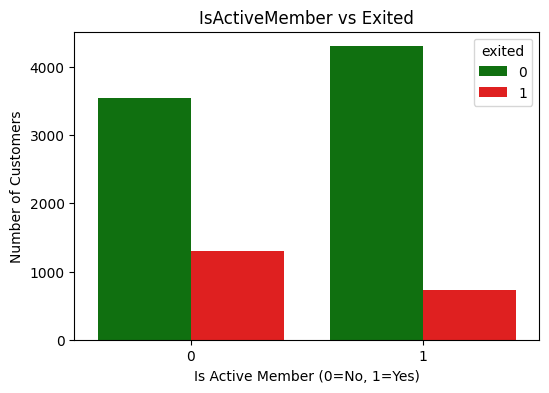

In [39]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='isactivemember', hue='exited', palette=['green','red'])
plt.title("IsActiveMember vs Exited")
plt.xlabel("Is Active Member (0=No, 1=Yes)")
plt.ylabel("Number of Customers")
plt.show()

C:\Users\ascom\AppData\Local\Temp\ipykernel_4568\803134332.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='exited', palette=['green','red'])


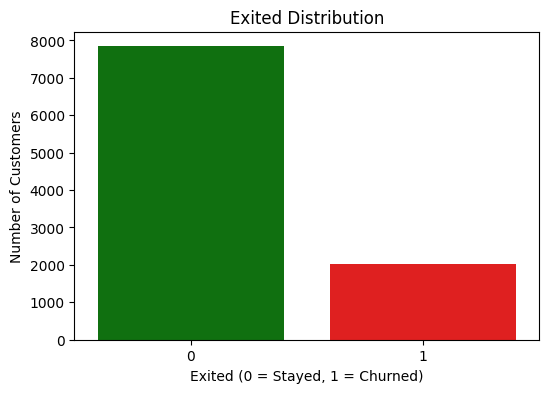

In [40]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='exited', palette=['green','red'])
plt.title("Exited Distribution")
plt.xlabel("Exited (0 = Stayed, 1 = Churned)")
plt.ylabel("Number of Customers")
plt.show()

In [41]:
# Categorical columns
# Geaography
df['geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

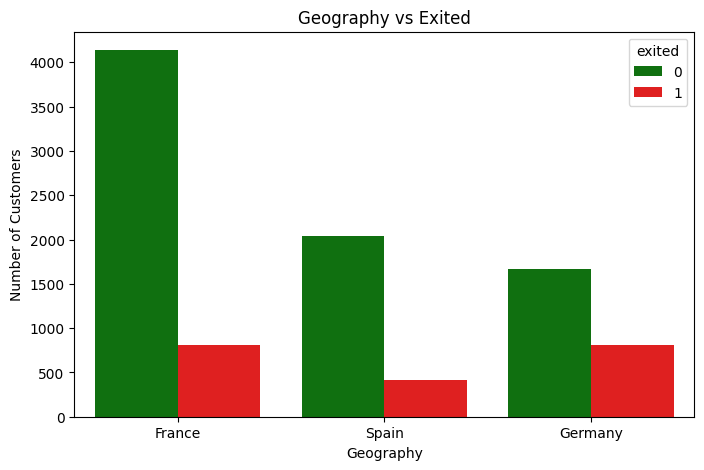

In [42]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='geography', hue='exited', palette=['green','red'])
plt.title("Geography vs Exited")
plt.xlabel("Geography")
plt.ylabel("Number of Customers")
plt.show()


In [43]:
#Gender
df['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [44]:
df['gender'] = df['gender'].map({'Male':0, 'Female':1})


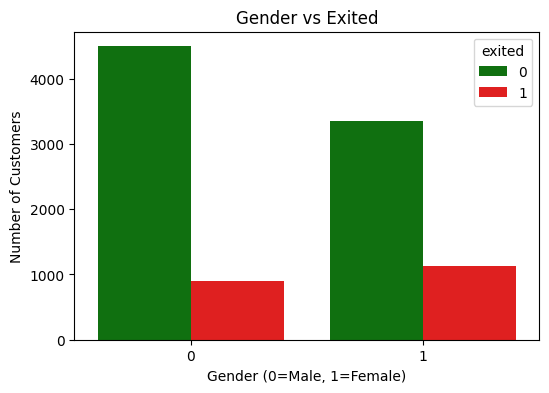

In [45]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='gender', hue='exited', palette=['green','red'])
plt.title("Gender vs Exited")
plt.xlabel("Gender (0=Male, 1=Female)")
plt.ylabel("Number of Customers")
plt.show()


* `BiVariate Viz`

In [46]:
## Analyze the interaction between Credit Score segments and Gender on churn rate.
# The table shows the percentage of customers who stayed vs exited within each group.
churn_by_score_gender = pd.crosstab(
    index=[df['creditscore_bin'], df['gender']], 
    columns=df['exited'],
    normalize='index'
) * 100

churn_by_score_gender = churn_by_score_gender.reset_index() 
churn_by_score_gender.columns = ['CreditScoreBin','Gender','Stayed(%)','Exited(%)']  
churn_by_score_gender


,CreditScoreBin,Gender,Stayed(%),Exited(%)
0,Low,0,80.669711,19.330289
1,Low,1,74.266793,25.733207
2,Fair,0,84.002230,15.997770
3,Fair,1,73.852295,26.147705
4,Good,0,85.035074,14.964926
5,Good,1,76.199262,23.800738
6,Excellent,0,83.883884,16.116116
7,Excellent,1,74.909964,25.090036


In [47]:
# Pivot table: Churn percentage for each Balance category × Credit Score bin
balance_credit_churn = pd.crosstab(
    index=[df['balance_bin'], df['creditscore_bin']],
    columns=df['exited'],
    normalize='index'
) * 100
balance_credit_churn.columns = ['Stayed(%)','Exited(%)']
balance_credit_churn


Stayed(%)  Exited(%)
balance_bin creditscore_bin                      
0-20k       Low              85.796105  14.203895
            Fair             85.264055  14.735945
            Good             87.005650  12.994350
            Excellent        86.277603  13.722397
20-50k      Low              46.153846  53.846154
            Fair             64.516129  35.483871
            Good             75.000000  25.000000
            Excellent        77.777778  22.222222
50-100k     Low              77.643505  22.356495
            Fair             80.896686  19.103314
            Good             79.329609  20.670391
            Excellent        81.818182  18.181818
100k+       Low              72.183709  27.816291
            Fair             74.794174  25.205826
            Good             76.805054  23.194946
            Excellent        74.640089  25.359911

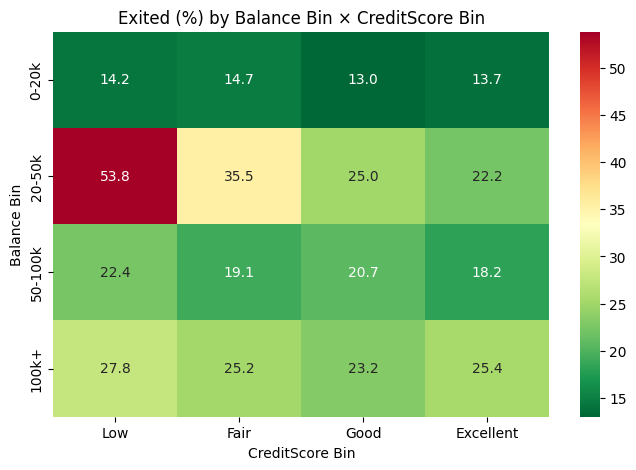

In [48]:
balance_credit_churn_heatmap = pd.crosstab(
    index=df['balance_bin'],
    columns=df['creditscore_bin'],
    values=df['exited'],
    aggfunc=lambda x: (x==1).mean()*100
)

plt.figure(figsize=(8,5))
sns.heatmap(
    balance_credit_churn_heatmap,
    annot=True, fmt=".1f",
    cmap='RdYlGn_r'  
)
plt.title("Exited (%) by Balance Bin × CreditScore Bin")
plt.ylabel("Balance Bin")
plt.xlabel("CreditScore Bin")
plt.show()


In [49]:
df_long = churn_by_score_gender.melt(
    id_vars=['CreditScoreBin','Gender'],
    value_vars=['Stayed(%)','Exited(%)'],
    var_name='Status',
    value_name='Percentage'
)


C:\Users\ascom\AppData\Local\Temp\ipykernel_4568\2398608968.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


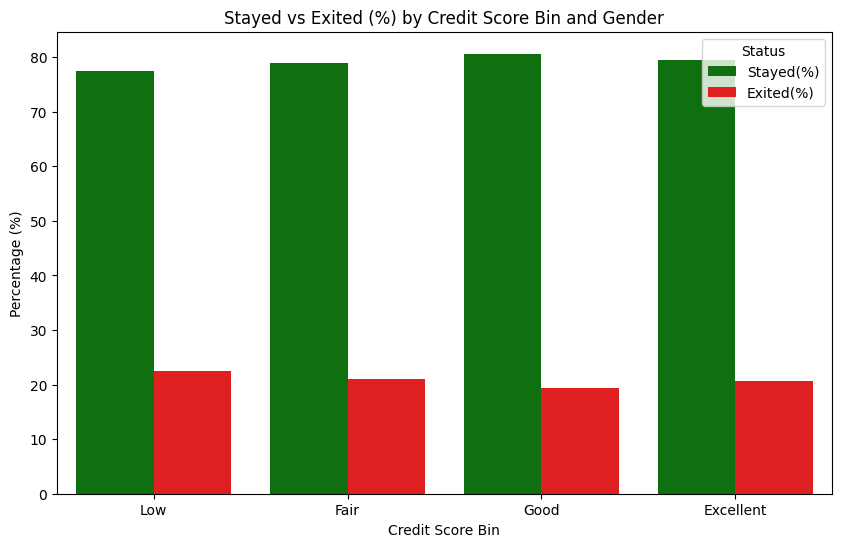

In [50]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_long,
    x='CreditScoreBin',
    y='Percentage',
    hue='Status',
    palette=['green','red'],
    ci=None
)
plt.title("Stayed vs Exited (%) by Credit Score Bin and Gender")
plt.ylabel("Percentage (%)")
plt.xlabel("Credit Score Bin")
plt.legend(title='Status')
plt.show()


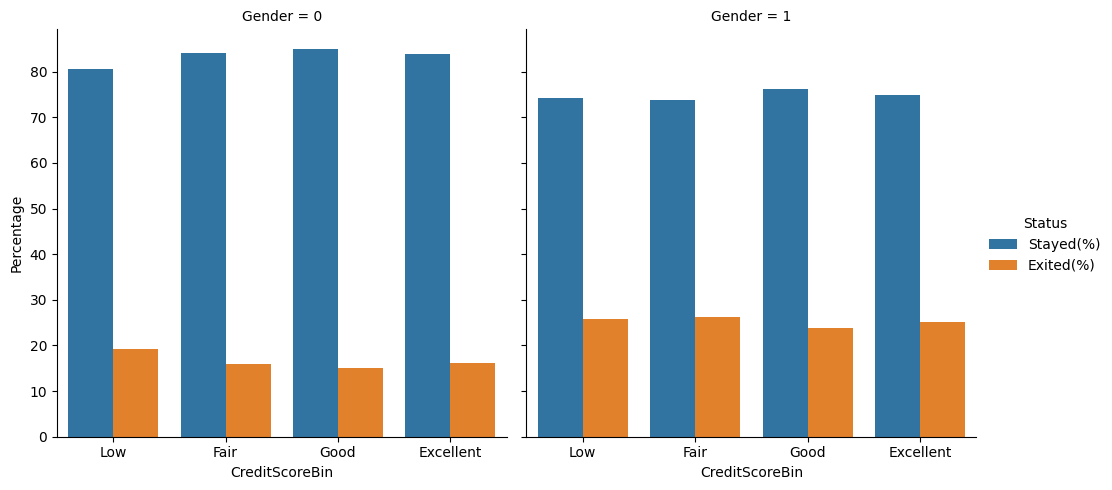

In [51]:
sns.catplot(
    data=df_long,
    x='CreditScoreBin',
    y='Percentage',
    hue='Status',
    col='Gender',
    kind='bar',
    height=5,
    aspect=1
)


In [52]:
#“While churn increases with age, further analysis shows that inactivity is the primary driver. 
# Inactive customers aged 51–60 and 61–70 exhibit extremely high churn rates (above 85%),
#  whereas active customers in the same age groups show significantly lower churn. 
# This indicates a strong interaction between age and activity status.”
age_activity_churn = pd.crosstab(
    index=[df['age_group'], df['isactivemember']],
    columns=df['exited'],
    normalize='index'
) * 100

age_activity_churn


exited                            0          1
age_group isactivemember                      
18-30     0               89.821616  10.178384
          1               95.065458   4.934542
31-40     0               85.062612  14.937388
          1               90.790068   9.209932
41-50     0               58.401305  41.598695
          1               74.588665  25.411335
51-60     0               14.285714  85.714286
          1               65.292842  34.707158
61-70     0               11.688312  88.311688
          1               85.826772  14.173228

In [53]:
older_customers = df[df['age_group'].isin(['51-60', '61-70'])]


In [54]:
#“Older inactive customers (51–70) are the highest churn risk.
#  Their balance is lower than active peers, but inactivity is the main driver. 
# Any retention strategy should target inactivity rather than focusing solely on balance.”
older_customers.groupby(
    ['age_group', 'isactivemember', 'exited']
)['balance'].agg(['mean', 'median', 'count'])


C:\Users\ascom\AppData\Local\Temp\ipykernel_4568\2848877874.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  older_customers.groupby(


mean      median  count
age_group isactivemember exited                                 
18-30     0              0                NaN         NaN      0
                         1                NaN         NaN      0
          1              0                NaN         NaN      0
                         1                NaN         NaN      0
31-40     0              0                NaN         NaN      0
                         1                NaN         NaN      0
          1              0                NaN         NaN      0
                         1                NaN         NaN      0
41-50     0              0                NaN         NaN      0
                         1                NaN         NaN      0
          1              0                NaN         NaN      0
                         1                NaN         NaN      0
51-60     0              0       90385.562500  111039.995     48
                         1       90463.359306  108602.115    288
          1              0       70711.659934   85845.430    301
                         1       87487.258875  108736.795    160
61-70     0              0       56006.096667       0.000      9
                         1       89450.307353  110335.605     68
          1              0       73323.488119   91991.650    218
                         1       97310.148056  116171.475     36

In [55]:
# "There is almost no linear correlation between HasCrCard, Balance, and EstimatedSalary. This suggests that credit card ownership and salary do not significantly influence account balance in this dataset."
df[['hascrcard', 'balance', 'estimatedsalary']].corr()

,hascrcard,balance,estimatedsalary
hascrcard,1.000000,-0.015527,-0.009649
balance,-0.015527,1.000000,0.013199
estimatedsalary,-0.009649,0.013199,1.000000


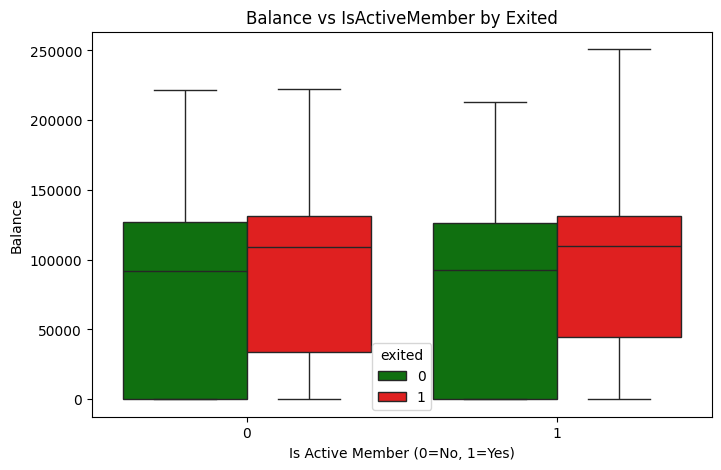

In [56]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=df,
    x='isactivemember',
    y='balance',
    hue='exited',
    palette=['green','red']
)
plt.title("Balance vs IsActiveMember by Exited")
plt.xlabel("Is Active Member (0=No, 1=Yes)")
plt.ylabel("Balance")
plt.show()


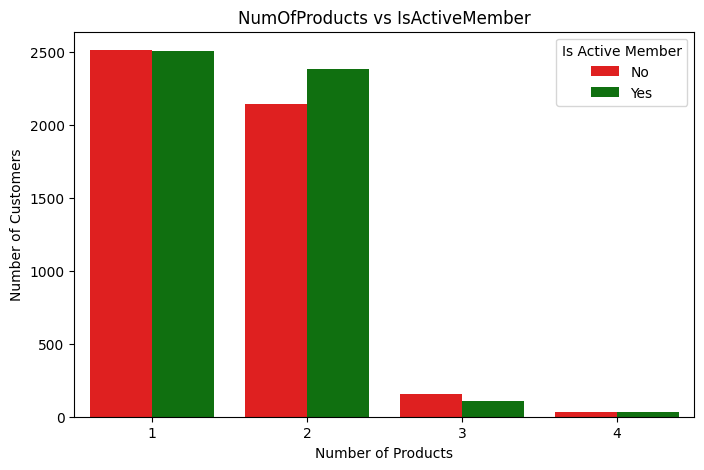

In [57]:
plt.figure(figsize=(8,5))
sns.countplot(
    data=df,
    x='numofproducts',
    hue='isactivemember',
    palette=['red','green']  
)
plt.title("NumOfProducts vs IsActiveMember")
plt.xlabel("Number of Products")
plt.ylabel("Number of Customers")
plt.legend(title="Is Active Member", labels=["No", "Yes"])
plt.show()


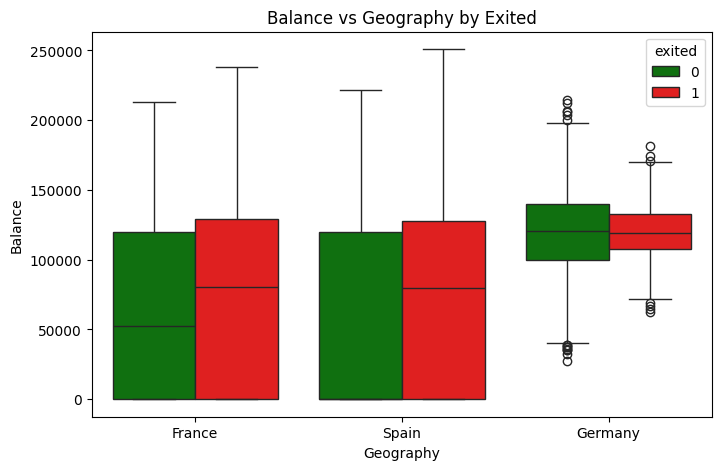

In [58]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=df,
    x='geography',
    y='balance',
    hue='exited',
    palette=['green','red']  # أخضر = Stayed, أحمر = Churned
)
plt.title("Balance vs Geography by Exited")
plt.xlabel("Geography")
plt.ylabel("Balance")
plt.show()


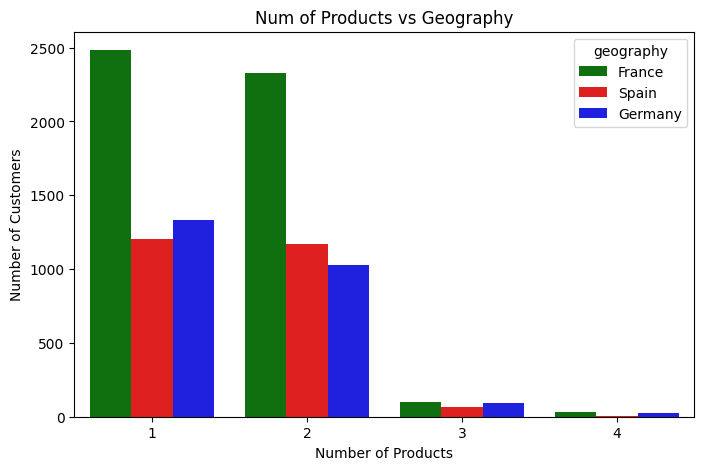

In [59]:
plt.figure(figsize=(8,5))
sns.countplot(
    data=df,
    x='numofproducts',
    hue='geography',
    palette=['green','red','blue'] 
)
plt.title("Num of Products vs Geography")
plt.xlabel("Number of Products")
plt.ylabel("Number of Customers")
plt.show()


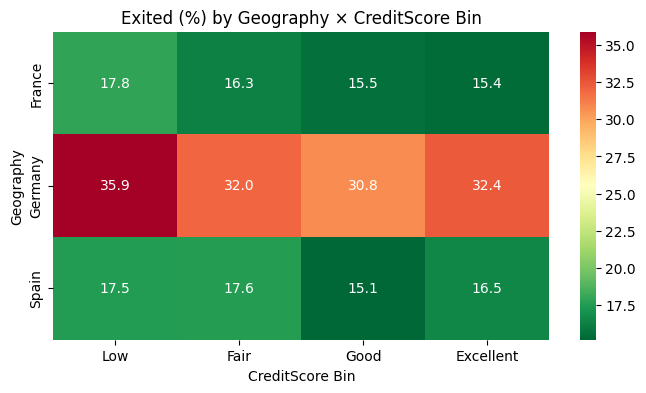

In [60]:
# Pivot table
geography_score_churn = pd.crosstab(
    index=df['geography'],
    columns=df['creditscore_bin'],
    values=df['exited'],
    aggfunc=lambda x: (x==1).mean()*100
)

plt.figure(figsize=(8,4))
sns.heatmap(geography_score_churn, annot=True, fmt=".1f", cmap='RdYlGn_r')
plt.title("Exited (%) by Geography × CreditScore Bin")
plt.ylabel("Geography")
plt.xlabel("CreditScore Bin")
plt.show()


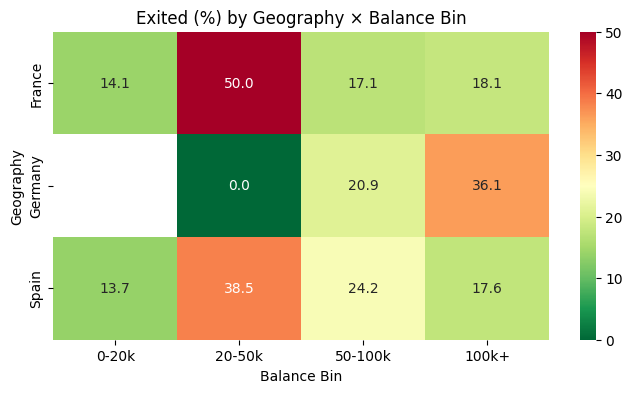

In [61]:
geography_balance_churn = pd.crosstab(
    index=df['geography'],
    columns=df['balance_bin'],
    values=df['exited'],
    aggfunc=lambda x: (x==1).mean()*100
)

plt.figure(figsize=(8,4))
sns.heatmap(geography_balance_churn, annot=True, fmt=".1f", cmap='RdYlGn_r')
plt.title("Exited (%) by Geography × Balance Bin")
plt.ylabel("Geography")
plt.xlabel("Balance Bin")
plt.show()


* `Split to train & test`

In [62]:
# to featueres & target 
X = data.drop(columns=['exited'], axis=1)
y = data['exited']

# Split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=45, stratify=y)

# Check shapes
print('X_train.shape \t', X_train.shape)
print('y_train.shape \t', y_train.shape)
print('***'*10)
print('X_test.shape \t', X_test.shape)
print('y_test.shape \t', y_test.shape)

X_train.shape 	 (8000, 10)
y_train.shape 	 (8000,)
******************************
X_test.shape 	 (2000, 10)
y_test.shape 	 (2000,)


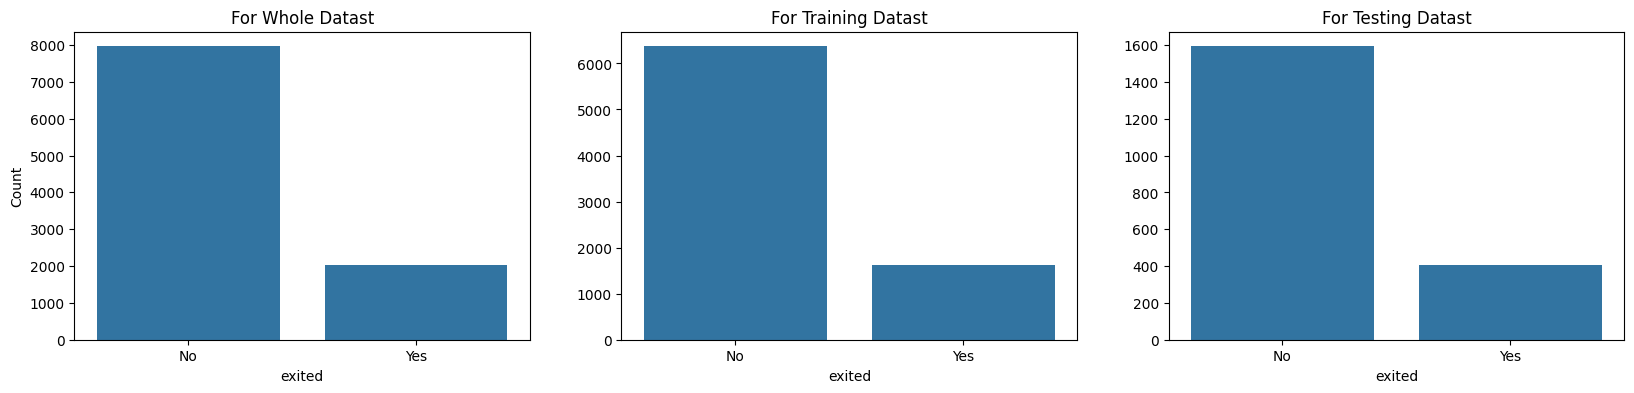

In [63]:
# plottting to check
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

# Whole dataset
plt.sca(ax[0])
sns.countplot(x=y)
plt.title('For Whole Datast')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

# train
plt.sca(ax[1])
sns.countplot(x=y_train)
plt.title('For Training Datast')
plt.ylabel('')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

# test
plt.sca(ax[2])
sns.countplot(x=y_test)
plt.title('For Testing Datast')
plt.ylabel('')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

* `Feature Selection & Preporcessing`

In [64]:
# slice cols
num_cols = ['age', 'creditscore', 'balance', 'estimatedsalary']
categ_cols = ['gender', 'geography']
ready_cols = list(set(X_train.columns.tolist()) - set(num_cols) - set(categ_cols))

In [65]:
# Numerical cols (num_cols) & Target cols --> ANOVA
_, p_val = f_classif(X=X_train[num_cols], y=y_train)
p_val   # All features p-value less than 0.05 --> Reject H0 --> There is an asscociation

array([4.53937410e-151, 9.93415956e-002, 4.93061528e-027, 3.77885631e-001])

In [66]:
from sklearn.feature_selection import chi2
X_cat_ohe = pd.get_dummies(X_train[categ_cols], drop_first=True)
chi2_stat, p_val = chi2(X_cat_ohe, y_train)

p_val


array([2.10648846e-11, 1.83464319e-45, 2.03111712e-05])

In [67]:
# Ready cols (ready_cols) & Target cols --> chi2
X_chi2 = pd.get_dummies(X_train[ready_cols], drop_first=True)
_, p_val = chi2(X_chi2, y_train)# All features p-value less than 0.05 --> Reject H0 --> There is an asscociation


In [68]:
# Pipeline

# Numerical: num_cols --> Imputing using median, and standardscaler
# Categorical: categ_cols ---> Imputing using mode, and OHE
# Ready_cols ---> Imputing mode


# For Numerical
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For Categorical
categ_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, drop='first'))
])

# For Ready cols
ready_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
])

# Combine all
preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_pipeline, num_cols),
    ('categorical', categ_pipeline, categ_cols),
    ('ready', ready_pipeline, ready_cols)
])

# Apply to train and test
X_train_final = preprocessor.fit_transform(X_train)
X_test_final = preprocessor.transform(X_test)

In [69]:
# Check train
X_train_final.shape, y_train.shape

((8000, 11), (8000,))

In [70]:
# Check test
X_test_final.shape, y_test.shape

((2000, 11), (2000,))

In [71]:
X_train.dtypes


creditscore          int64
geography           object
gender              object
age                  int64
tenure               int64
balance            float64
numofproducts        int64
hascrcard            int64
isactivemember       int64
estimatedsalary    float64
dtype: object

* `Deal with imbalanced dataset`

In [72]:
# 1. prepare class_weights for solving imbalance dataset
vals_count = 1 - (np.bincount(y_train) / len(y_train))
vals_count = vals_count / sum(vals_count)

dict_weights = {}
for i in range(2):  # 2 classes (0, 1)
    dict_weights[i] = vals_count[i]

# to model
dict_weights

{0: 0.20375, 1: 0.79625}

In [73]:
# 2. Using SMOTE for over sampling
over = SMOTE(k_neighbors=5, sampling_strategy=0.7, random_state=45)
X_train_final_resampled, y_train_resampled = over.fit_resample(X_train_final, y_train)

In [74]:
# Create fodler for the models
MODELS_FOLDER_PATH = os.path.join(os.getcwd(), '..', 'models')
os.makedirs(MODELS_FOLDER_PATH, exist_ok=True)

In [75]:
# dump the preprocessor
joblib.dump(preprocessor, os.path.join(MODELS_FOLDER_PATH, 'preprocessor.pkl'))

['d:\\AI\\Agor\\ML\\churn project\\notebooks\\..\\models\\preprocessor.pkl']

* `Building Models`
> Let's consider the evaluation metric to be f1_score

1. Using Logistic Regression

In [76]:
# 1. Using logisit -- without considering the imabalancing data
log_clf = LogisticRegression(C=1.5)
log_clf.fit(X_train_final, y_train)

# Predict and evaluate
y_pred_train_log = log_clf.predict(X_train_final)
y_pred_test_log = log_clf.predict(X_test_final)

# Using f1_score
score_train_log = f1_score(y_train, y_pred_train_log)
score_test_log = f1_score(y_test, y_pred_test_log)


print(f'The f1_score using Logistic model for Training Dataset is {score_train_log*100:.3f}')
print(f'The f1_score using Logistic model for Testing Dataset is {score_test_log*100:.3f}')

The f1_score using Logistic model for Training Dataset is 32.437
The f1_score using Logistic model for Testing Dataset is 30.631


In [77]:
# 2. Using logisit -- with considering the imabalancing data using class_weights
log_clf = LogisticRegression(C=1.5, class_weight=dict_weights)
log_clf.fit(X_train_final, y_train)

# Predict and evaluate
y_pred_train_log = log_clf.predict(X_train_final)
y_pred_test_log = log_clf.predict(X_test_final)

# Using f1_score
score_train_log = f1_score(y_train, y_pred_train_log)
score_test_log = f1_score(y_test, y_pred_test_log)

print(f'The f1_score using Logistic model for Training Dataset with class_weigths is {score_train_log*100:.3f}')
print(f'The f1_score using Logistic model for Testing Dataset with class_weigths is {score_test_log*100:.3f}')

The f1_score using Logistic model for Training Dataset with class_weigths is 50.055
The f1_score using Logistic model for Testing Dataset with class_weigths is 48.213


In [78]:
# 3. Using logisit -- with considering the imabalancing data using oversampled data (SMOTE)
log_clf = LogisticRegression(C=1.5)
log_clf.fit(X_train_final_resampled, y_train_resampled)

# Predict and evaluate
y_pred_train_log = log_clf.predict(X_train_final)
y_pred_test_log = log_clf.predict(X_test_final)

# Using f1_score
score_train_log = f1_score(y_train, y_pred_train_log)
score_test_log = f1_score(y_test, y_pred_test_log)

print(f'The f1_score using Logistic model for Training Dataset with SMOTE is {score_train_log*100:.3f}')
print(f'The f1_score using Logistic model for Testing Dataset with SMOTE is {score_test_log*100:.3f}')

The f1_score using Logistic model for Training Dataset with SMOTE is 49.550
The f1_score using Logistic model for Testing Dataset with SMOTE is 49.064


<Axes: >

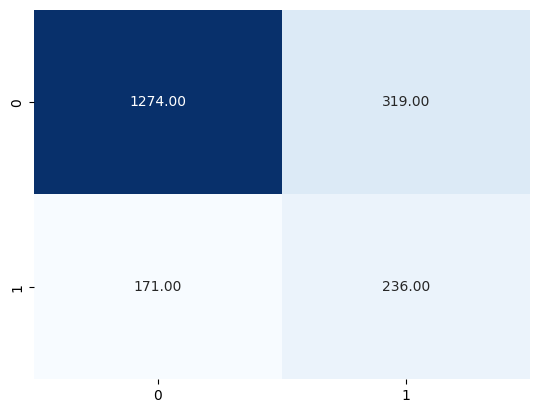

In [79]:
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred_test_log), cmap='Blues', cbar=False, annot=True, fmt='.2f')

In [80]:
# clf report
print(classification_report(y_test, y_pred_test_log))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1593
           1       0.43      0.58      0.49       407

    accuracy                           0.76      2000
   macro avg       0.65      0.69      0.66      2000
weighted avg       0.79      0.76      0.77      2000



* `RandomForest`

In [81]:
# Using RF -- With class_weights
forst_clf = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=45, class_weight=dict_weights)
forst_clf.fit(X_train_final, y_train)

# Predict and evaluate
y_pred_train_forest = forst_clf.predict(X_train_final)
y_pred_test_foerst = forst_clf.predict(X_test_final)

# Using f1_score
score_train_forest = f1_score(y_train, y_pred_train_forest)
score_test_forest = f1_score(y_test, y_pred_test_foerst)

print(f'The f1_score using RF model for Training Dataset with class_weights is {score_train_forest*100:.3f}')
print(f'The f1_score using RF model for Testing Dataset with class_weights is {score_test_forest*100:.3f}')

The f1_score using RF model for Training Dataset with class_weights is 60.746
The f1_score using RF model for Testing Dataset with class_weights is 58.896


In [82]:
# Using RF -- With SMOTE
forst_clf = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=45)
forst_clf.fit(X_train_final_resampled, y_train_resampled)

# Predict and evaluate
y_pred_train_forest = forst_clf.predict(X_train_final)
y_pred_test_foerst = forst_clf.predict(X_test_final)

# Using f1_score
score_train_forest = f1_score(y_train, y_pred_train_forest)
score_test_forest = f1_score(y_test, y_pred_test_foerst)

print(f'The f1_score using RF model for Training Dataset with SMOTE is {score_train_forest*100:.3f}')
print(f'The f1_score using RF model for Testing Dataset with SMOTE is {score_test_forest*100:.3f}')

The f1_score using RF model for Training Dataset with SMOTE is 61.941
The f1_score using RF model for Testing Dataset with SMOTE is 58.333


* `RF-Tuning`

In [83]:
forest_base_clf = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=45, class_weight=dict_weights)

# Your space to search
params_best_grid = {
            'n_estimators': np.arange(50, 400, 50),
            'max_depth': np.arange(6, 10, 2)
}
grid_search_forest = GridSearchCV(estimator=forest_base_clf,param_grid=params_best_grid,cv=5,n_jobs=1,  verbose=4,scoring='f1')
grid_search_forest.fit(X_train_final, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END ......max_depth=6, n_estimators=50;, score=0.620 total time=   0.5s
[CV 2/5] END ......max_depth=6, n_estimators=50;, score=0.571 total time=   0.3s
[CV 3/5] END ......max_depth=6, n_estimators=50;, score=0.586 total time=   0.3s
[CV 4/5] END ......max_depth=6, n_estimators=50;, score=0.615 total time=   0.3s
[CV 5/5] END ......max_depth=6, n_estimators=50;, score=0.565 total time=   0.3s
[CV 1/5] END .....max_depth=6, n_estimators=100;, score=0.627 total time=   0.8s
[CV 2/5] END .....max_depth=6, n_estimators=100;, score=0.577 total time=   0.7s
[CV 3/5] END .....max_depth=6, n_estimators=100;, score=0.589 total time=   0.7s
[CV 4/5] END .....max_depth=6, n_estimators=100;, score=0.617 total time=   0.7s
[CV 5/5] END .....max_depth=6, n_estimators=100;, score=0.573 total time=   0.8s
[CV 1/5] END .....max_depth=6, n_estimators=150;, score=0.636 total time=   1.1s
[CV 2/5] END .....max_depth=6, n_estimators=150;

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: 0.20375,
                                                            1: 0.79625},
                                              max_depth=5, n_estimators=150,
                                              random_state=45),
             n_jobs=1,
             param_grid={'max_depth': array([6, 8]),
                         'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350])},
             scoring='f1', verbose=4)

In [84]:
# The best score according to your scoring & The best combination of what you search in
grid_search_forest.best_score_, grid_search_forest.best_params_

(0.6149385518316274, {'max_depth': 8, 'n_estimators': 300})

In [85]:
# The forest after tuning
forest_tuned = grid_search_forest.best_estimator_

# Predict and evaluate
y_pred_train_forest_tuned = forest_tuned.predict(X_train_final)
y_pred_test_forest_tuned = forest_tuned.predict(X_test_final)

# Using f1_score
score_train_forest_tuned = f1_score(y_train, y_pred_train_forest_tuned)
score_test_forest_tuned = f1_score(y_test, y_pred_test_forest_tuned)

print(f'The f1_score using tuned RF model for Training Dataset with class_weigths is {score_train_forest_tuned*100:.3f}')
print(f'The f1_score using tuned RF model for Testing Dataset with class_weigths is {score_test_forest_tuned*100:.3f}')

The f1_score using tuned RF model for Training Dataset with class_weigths is 69.203
The f1_score using tuned RF model for Testing Dataset with class_weigths is 60.965


In [86]:
forest_tuned.feature_importances_

array([0.37466067, 0.04773849, 0.09525522, 0.05132155, 0.02728097,
       0.06027386, 0.00642445, 0.24083171, 0.06301029, 0.00634122,
       0.02686157])

In [87]:
# Get the features out from the preprocessor
features_after = [name.split('__')[1] for name in preprocessor.get_feature_names_out()]
features_after

['age',
 'creditscore',
 'balance',
 'estimatedsalary',
 'gender_Male',
 'geography_Germany',
 'geography_Spain',
 'numofproducts',
 'isactivemember',
 'hascrcard',
 'tenure']

In [88]:
# Feature Importance from RF
forest_tuned_importance = pd.DataFrame({'feature': features_after, 
                              'importance': forest_tuned.feature_importances_}).sort_values('importance', ascending=False)
forest_tuned_importance

,feature,importance
0,age,0.374661
7,numofproducts,0.240832
2,balance,0.095255
8,isactivemember,0.063010
5,geography_Germany,0.060274
3,estimatedsalary,0.051322
1,creditscore,0.047738
4,gender_Male,0.027281
10,tenure,0.026862
6,geography_Spain,0.006424


In [89]:
# Downlaod it if you are satisifed with the above model
joblib.dump(forest_tuned, os.path.join(MODELS_FOLDER_PATH, 'forest_tuned.pkl'))

['d:\\AI\\Agor\\ML\\churn project\\notebooks\\..\\models\\forest_tuned.pkl']